In [3]:
from scipy.stats import spearmanr, pearsonr

from bertscore import BERTScore
from conventional_metrics import BLEU, METEOR
from scm import SCM, ContextualSCM
from wmd import WMD, ContextualWMD
from common import Evaluator
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/home/xstefan3/miniconda3/envs/new_hf/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
# from pathlib import Path

# if not (Path('embeddings')/'cc.en.300.bin').exists():
#     %mkdir -p embeddings
#     ! wget -nc https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz -O embeddings/cc.en.300.bin.gz
#     ! gzip -d embeddings/cc.en.300.bin.gz

### Mutual correlations of metrics

In [ ]:
metrics = [
    ContextualWMD(tgt_lang="en"),
    ContextualSCM(tgt_lang="en"),
    BERTScore(tgt_lang="en"),
    BLEU(),
    METEOR(),
    SCM(tgt_lang="en", use_tfidf=False),
    SCM(tgt_lang="en", use_tfidf=True),
    WMD(tgt_lang="en"),
]

correlations = {m.label: {} for m in metrics}
correlations["human"] = {}

correlations_p = correlations.copy()
reports = []
langs = Evaluator.langs_qm

selected_lang_pairs = [pair for pair in langs if pair.split("-")[-1] == "en"]

for lang_pair in selected_lang_pairs:
    print("Evaluating lang pair %s" % lang_pair)
    evaluator = Evaluator("data_dir", lang_pair, metrics, judgements_type="MQM", firstn=1000)
    report = evaluator.evaluate()
    reports.append(report)
 
    human_judgements = report["human"]
#     for metric_label, vals in report.items():
#         correlations[metric_label][lang_pair] = spearmanr(vals, human_judgements).correlation
#         correlations_p[metric_label][lang_pair] = pearsonr(vals, human_judgements)[0]

    sns.heatmap(pd.DataFrame(report).applymap(float).corr(method="pearson").applymap(abs), annot=True)
    plt.show()
    sns.heatmap(pd.DataFrame(report).applymap(float).corr(method="spearman").applymap(abs), annot=True)
    plt.show()

# corrs_df = pd.DataFrame(correlations)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xstefan3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xstefan3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/xstefan3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xstefan3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xstefan3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xstefan3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Evaluating lang pair zh-en


BERT embeddings:  52%|█████▏    | 52/100 [00:37<00:36,  1.33it/s]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xstefan3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xstefan3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/xstefan3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xstefan3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xstefan3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xstefan3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Evaluating lang pair zh-en


BERT embeddings: 167it [04:46,  1.71s/it]                         
BERT embeddings: 167it [05:14,  1.88s/it]                         
WMD_contextual: construct contextual embeddings: 2000it [00:06, 305.13it/s]
BERT embeddings: 167it [04:54,  1.76s/it]                         
BERT embeddings: 167it [05:21,  1.92s/it]                         
SCM_contextual: construct contextual embeddings: 2000it [00:05, 333.83it/s]
  0%|          | 0/84972 [00:00<?, ?it/s]/home/xstefan3/miniconda3/envs/new_hf/lib/python3.8/site-packages/gensim/models/keyedvectors.py:772: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]
100%|██████████| 729/729 [00:41<00:00, 17.75it/s]
BERTScore: 32it [00:06,  4.63it/s]                        
WMD: 100%|██████████| 1000/1000 [00:05<00:00, 177.47it/s]


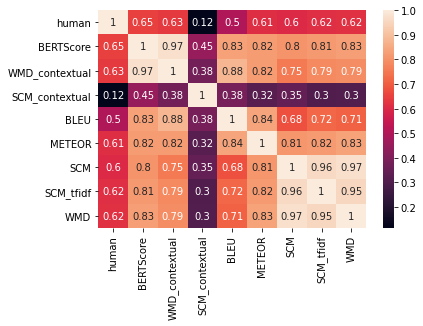

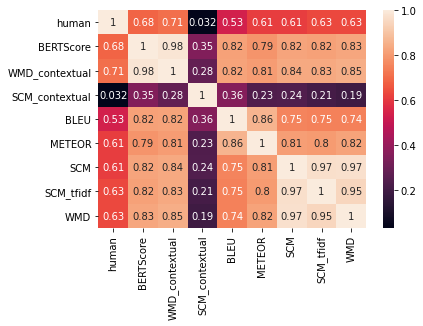

In [2]:
# subsample evaluation

metrics = [
    BERTScore(tgt_lang="en"),
    ContextualWMD(tgt_lang="en"),
    ContextualSCM(tgt_lang="en"),
    BLEU(),
    METEOR(),
    SCM(tgt_lang="en", use_tfidf=False),
    SCM(tgt_lang="en", use_tfidf=True),
    WMD(tgt_lang="en"),
]

correlations = {m.label: {} for m in metrics}
correlations["human"] = {}

correlations_p = correlations.copy()
reports = []
langs = Evaluator.langs_qm

selected_lang_pairs = [pair for pair in langs if pair.split("-")[-1] == "en"]

for lang_pair in selected_lang_pairs:
    print("Evaluating lang pair %s" % lang_pair)
    evaluator = Evaluator("data_dir", lang_pair, metrics, judgements_type="MQM")
    report = evaluator.evaluate()
    reports.append(report)
 
    human_judgements = report["human"]
#     for metric_label, vals in report.items():
#         correlations[metric_label][lang_pair] = spearmanr(vals, human_judgements).correlation
#         correlations_p[metric_label][lang_pair] = pearsonr(vals, human_judgements)[0]

    sns.heatmap(pd.DataFrame(report).applymap(float).corr(method="pearson").applymap(abs), annot=True)
    plt.show()
    sns.heatmap(pd.DataFrame(report).applymap(float).corr(method="spearman").applymap(abs), annot=True)
    plt.show()

# corrs_df = pd.DataFrame(correlations)

Alternatively, reload `report` computed elsewhere, i.e. in `main.py` 

<AxesSubplot:>

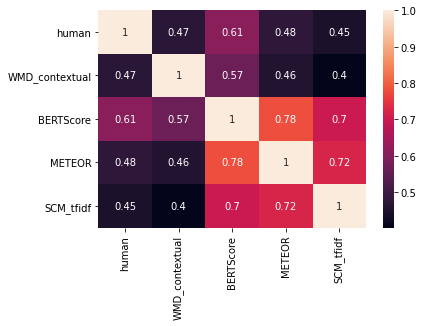

In [3]:
import pandas as pd
import seaborn as sns
report = pd.read_pickle("report_mqm_df.pkl")

sns.heatmap(report.applymap(float).corr(method="spearman").applymap(abs), annot=True)

In [2]:
report

,human,WMD_contextual,BERTScore,METEOR,SCM_tfidf
0,-0.666667,0.355264,0.901030,0.827573,0.867888
1,-0.666667,0.355264,0.901030,0.827573,0.867888
2,-0.666667,0.321190,0.917980,0.859674,0.891263
3,-0.666667,0.335755,0.881174,0.810398,0.867888
4,-0.666667,0.250069,0.891851,0.821158,0.885049
...,...,...,...,...,...
4995,-6.700000,0.315779,0.407933,0.559072,0.540618
4996,-6.700000,0.315294,0.496657,0.624367,0.540618
4997,-6.700000,0.528196,0.447775,0.420565,0.484708
4998,-6.700000,0.514351,0.478217,0.459082,0.484708


## Correlations of metrics to Expert Scalar Quality Metrics (eSQM) per language

In [ ]:
# Pearson
corrs_p = pd.concat([pd.DataFrame(report).corr(method="pearson").abs()["human"] for report in reports], axis=1)
corrs_p.columns = selected_lang_pairs
sns.heatmap(pd.DataFrame(corrs_p), annot=True)

In [ ]:
# Spearman
corrs_p = pd.concat([pd.DataFrame(report).corr(method="spearman").abs()["human"] for report in reports], axis=1)
corrs_p.columns = selected_lang_pairs
sns.heatmap(pd.DataFrame(corrs_p), annot=True)

#### Old versions

In [ ]:
# Pearson
corrs_p = pd.concat([pd.DataFrame(report).corr(method="pearson").abs()["human"] for report in reports], axis=1)
corrs_p.columns = selected_lang_pairs
sns.heatmap(pd.DataFrame(corrs_p), annot=True)

In [ ]:
# Spearman
corrs_p = pd.concat([pd.DataFrame(report).corr(method="spearman").abs()["human"] for report in reports], axis=1)
corrs_p.columns = selected_lang_pairs
sns.heatmap(pd.DataFrame(corrs_p), annot=True)